In [1]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import torch
import numpy as np
import datetime
from torch.utils.data import Dataset

%matplotlib inline

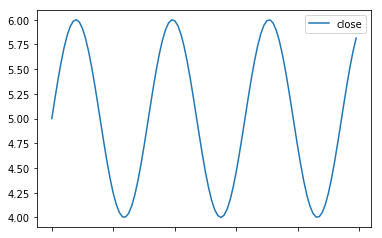

In [5]:
sine_series = np.sin(np.arange(100)*0.2) + 5
sine_df = pd.DataFrame(sine_series).rename(index=str, columns={0: 'close'})
_ = sine_df.plot()

### Create a fictitious financial data using `sine` function with `ohlc`!

In [7]:
NUM_DAYS = 1500
date_col = [datetime.date.today() + datetime.timedelta(days=i) for i in range(NUM_DAYS)]
aranged_values = [np.repeat(np.sin(i*0.2) + 5, 6) for i in range(1, NUM_DAYS+1)]
# aranged_values = [np.repeat(np.sin(i) + 5, 6) for i in range(1, NUM_DAYS+1)]
temp_df = pd.DataFrame(aranged_values,
                       columns=['date', 'open', 'high', 'low', 'close', 'volume'])
temp_df.iloc[:, 0] = date_col
temp_df.to_csv('../iexfinance/iexdata/SINE')

In [8]:
temp_df.head()

,date,open,high,low,close,volume
0,2018-10-09,5.198669,5.198669,5.198669,5.198669,5.198669
1,2018-10-10,5.389418,5.389418,5.389418,5.389418,5.389418
2,2018-10-11,5.564642,5.564642,5.564642,5.564642,5.564642
3,2018-10-12,5.717356,5.717356,5.717356,5.717356,5.717356
4,2018-10-13,5.841471,5.841471,5.841471,5.841471,5.841471


In [9]:
close = temp_df.close
close.describe()

count    1500.000000
mean        5.003062
std         0.707546
min         4.000010
25%         4.297282
50%         5.005314
75%         5.708988
max         6.000000
Name: close, dtype: float64

In [10]:
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm

[Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)
is about whether the `gamma` term is big enough. If big enough, then it's not `stationary`, since it's a random walk process; recall, random walk is not stationary process, as variance grows respect to `time`. Time-series is often about [stationary process](https://en.wikipedia.org/wiki/Stationary_process)...

In [11]:
adfuller_test = sm.tsa.adfuller(close)
adfuller_test = pd.Series(adfuller_test[:4], index=['ADF Statistic',
                                                    'p-value',
                                                    '#Lags Used',
                                                    'Number of Observations Used'])
adfuller_test

ADF Statistic                 -7.013004e+13
p-value                        0.000000e+00
#Lags Used                     1.000000e+00
Number of Observations Used    1.498000e+03
dtype: float64

#### Actually, `sine` nor `cosine` functions are `stationary` since there is nothing stochastic.
#### But suppose we didn't know that this was  from a `sine` function... Let's model them.
### 1. Try `Autoregressive (AR) Model` ?
It should obviously work, but to demonstrate...
$$
x_t = b_0 + b_1 x_{t-1} + b_2 x_{t - 2} + \ldots + b_p x_{t - p} + \epsilon_t
$$

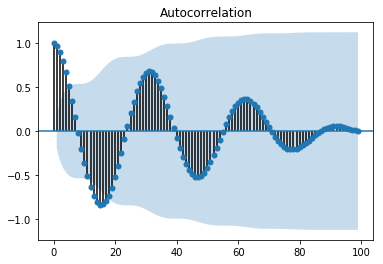

In [12]:
_ = plot_acf(close[:100])

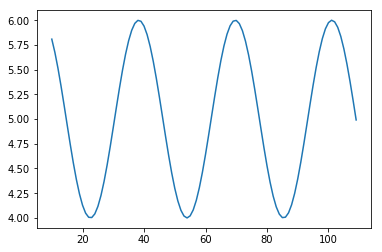

In [13]:
ar_model = sm.tsa.AR(close)
ar_model_fit = ar_model.fit(maxlag=10, trend='nc')
_ = plt.plot(ar_model_fit.fittedvalues[:100])

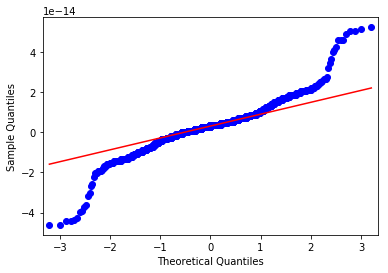

In [14]:
_ = qqplot(ar_model_fit.resid, line='q')

#### Looks like AR Model is enough to predict `Sine` function. ( y-axis is 1e-14, btw)

Note that I have limitted maxlag=10, but we can always increase it to over/under-fit
Also, financial data wouldn't be so easy like this...

#### Let's use some real data, named Apple Inc.

In [15]:
temp_df = pd.read_csv('../iexfinance/iexdata/AAPL')
close = temp_df['close']
close.describe()

count    1259.000000
mean      119.489676
std        36.841176
min        58.877600
25%        93.329800
50%       109.948700
75%       146.726450
max       228.360000
Name: close, dtype: float64

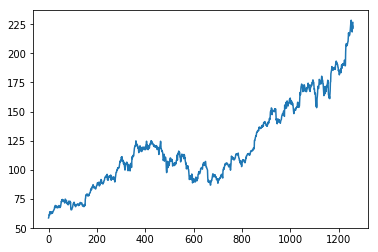

In [16]:
close.plot()

#### This is obviously not stationary, so try the difference

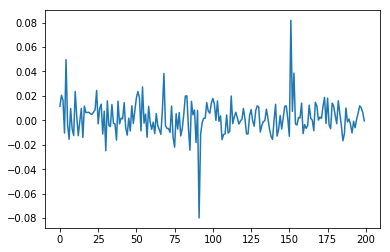

In [17]:
pct_change = close.pct_change().shift(-1)[:-1]
_ = pct_change[:200].plot()

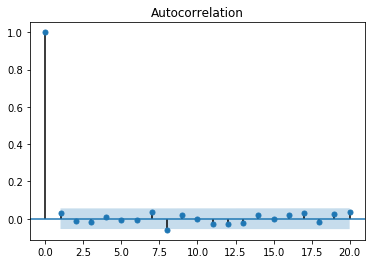

In [18]:
_ = plot_acf(pct_change, lags=20)

In [19]:
adfuller_test = sm.tsa.adfuller(pct_change)
adfuller_test = pd.Series(adfuller_test[:4], index=['ADF Statistic',
                                                    'p-value',
                                                    '#Lags Used',
                                                    'Number of Observations Used'])
adfuller_test

ADF Statistic                   -34.412054
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1257.000000
dtype: float64

### This is now stationary, so that's good. Just a side note, decompose still runs w/o a surprise; it doesn't do anything, in this case

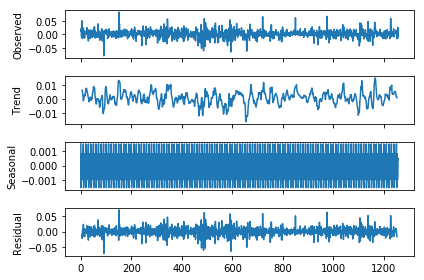

In [20]:
decompose = sm.tsa.seasonal_decompose(pct_change, freq = 10)
_ = decompose.plot()

### Let's use `ARMA` instead of `AR` process...

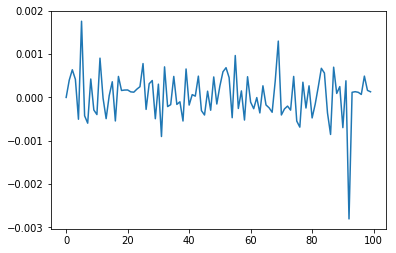

In [21]:
arma_model = sm.tsa.ARMA(pct_change, (2, 1))
arma_model_fit = arma_model.fit(trend='nc')
_ = plt.plot(arma_model_fit.fittedvalues[:100])

In [22]:
arma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 1258
Model:                     ARMA(2, 1)   Log Likelihood                3556.019
Method:                       css-mle   S.D. of innovations              0.014
Date:                Tue, 09 Oct 2018   AIC                          -7104.039
Time:                        07:48:40   BIC                          -7083.490
Sample:                             0   HQIC                         -7096.316
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.close     0.2797      1.565      0.179      0.858      -2.788       3.347
ar.L2.close    -0.0150      0.059     -0.256      0.798      -0.130       0.100
ma.L1.close    -0.2449      1.565     -0.156      0.876      -3.313       2.823
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.8283           +0.0000j            4.8283            0.0000
AR.2           13.7814           +0.0000j           13.7814            0.0000
MA.1            4.0835           +0.0000j            4.0835            0.0000
-----------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 1258
Model:                     ARMA(2, 2)   Log Likelihood                3557.157
Method:                       css-mle   S.D. of innovations              0.014
Date:                Tue, 09 Oct 2018   AIC                          -7104.313
Time:                        07:48:42   BIC                          -7078.627
Sample:                             0   HQIC                         -7094.660
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.close    -0.6511      0.083     -7.871      0.000      -0.813      -0.489
ar.L2.close    -0.9430      0.064    -14.706      0.000      -1.069      -0.817
ma.L1.close     0.6592      0.098      6.751      0.000       0.468       0.851
ma.L2.close     0.9299      0.065     14.384      0.000       0.803       1.057
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3452           -0.9702j            1.0298           -0.3044
AR.2           -0.3452           +0.9702j            1.0298            0.3044
MA.1           -0.3544           -0.9746j            1.0370           -0.3055
MA.2           -0.3544           +0.9746j            1.0370            0.3055
-----------------------------------------------------------------------------
"""

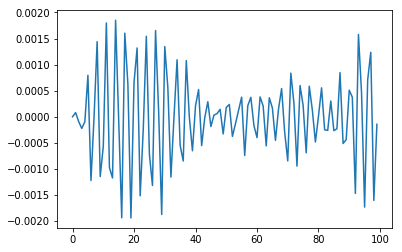

In [23]:
arma_model = sm.tsa.ARMA(pct_change, (2, 2))
arma_model_fit = arma_model.fit(trend='nc')
_ = plt.plot(arma_model_fit.fittedvalues[:100])
arma_model_fit.summary()

#### hmm, interestingly, drastic difference in p-values between (2, 1) vs (2, 2)

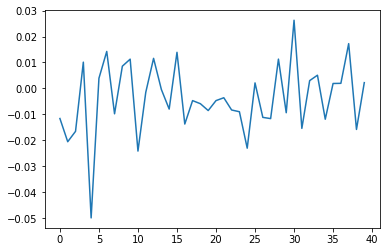

In [24]:
_ = plt.plot((arma_model_fit.fittedvalues - pct_change)[:40])

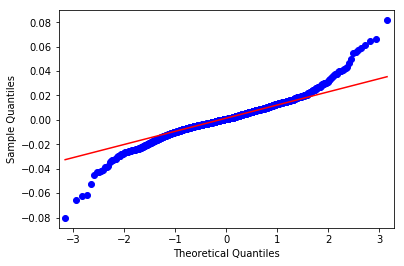

In [25]:
_ = qqplot(arma_model_fit.resid, line='q')

### Ok, test ARIMA

In [26]:
arima_fit = sm.tsa.ARIMA(pct_change, (3,2,0)).fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.close   No. Observations:                 1256
Model:                 ARIMA(3, 2, 0)   Log Likelihood                3087.858
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 09 Oct 2018   AIC                          -6165.717
Time:                        07:48:49   BIC                          -6140.039
Sample:                             2   HQIC                         -6156.066
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.427e-06      0.000      0.026      0.979      -0.000       0.000
ar.L1.D2.close    -1.1684      0.026    -45.317      0.000      -1.219      -1.118
ar.L2.D2.close    -0.8779      0.034    -26.009      0.000      -0.944      -0.812
ar.L3.D2.close    -0.4075      0.026    -15.742      0.000      -0.458      -0.357
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3693           -0.0000j            1.3693           -0.5000
AR.2           -0.3925           -1.2798j            1.3387           -0.2974
AR.3           -0.3925           +1.2798j            1.3387            0.2974
-----------------------------------------------------------------------------
"""

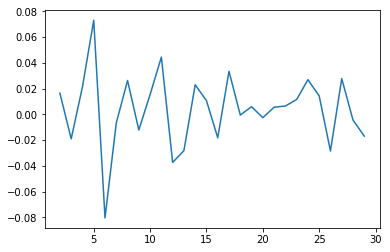

In [27]:
VALUE = 30
_ = plt.plot((pct_change[:VALUE] - arima_fit.fittedvalues[:VALUE]).dropna())

### Well `ARIMA` could be applied directly, actually

In [28]:
arima_fit = sm.tsa.ARIMA(close, (3,2,0)).fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.close   No. Observations:                 1257
Model:                 ARIMA(3, 2, 0)   Log Likelihood               -2594.489
Method:                       css-mle   S.D. of innovations              1.906
Date:                Tue, 09 Oct 2018   AIC                           5198.979
Time:                        07:48:54   BIC                           5224.661
Sample:                             2   HQIC                          5208.631
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0011      0.022      0.050      0.960      -0.042       0.044
ar.L1.D2.close    -0.7037      0.027    -25.910      0.000      -0.757      -0.650
ar.L2.D2.close    -0.4854      0.031    -15.842      0.000      -0.545      -0.425
ar.L3.D2.close    -0.2823      0.027    -10.330      0.000      -0.336      -0.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5693           -0.0000j            1.5693           -0.5000
AR.2           -0.0750           -1.5006j            1.5024           -0.2580
AR.3           -0.0750           +1.5006j            1.5024            0.2580
-----------------------------------------------------------------------------
"""

#### Wonder why the heck p values are all zeros... I mean, seriously?

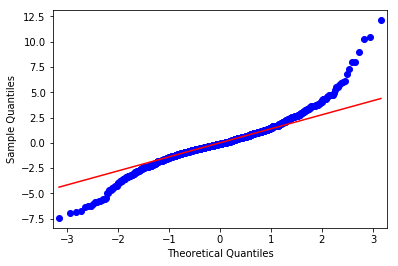

In [29]:
_ = qqplot(arima_fit.resid, line='q')

### `ARIMA` CURVE FITTING RESULT

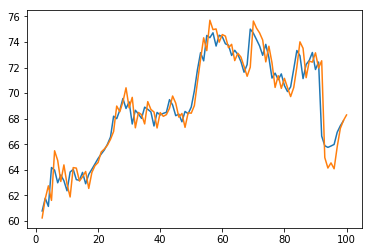

In [30]:
plt.plot(close[2:100])
plt.plot(arima_fit.predict(2, 100, typ='levels'))

## Feel like this chart should tell me that everything is howgwash ...

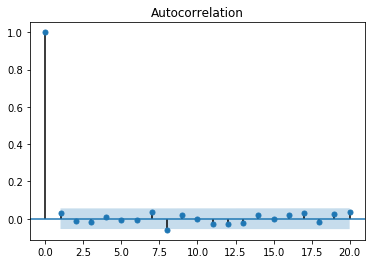

In [31]:
_ = plot_acf(pct_change, lags=20)

### OK, time to check `Akaike Information Criterion(AIC)` on `ARMA`... 
Discussions about [AIC](https://stats.stackexchange.com/questions/215654/what-does-the-akaike-information-criterion-aic-score-of-a-model-mean) in `stack exchange`

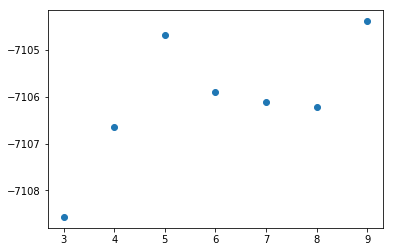

In [32]:
def get_best_ar_process(data, p_value):
    p_values = np.arange(3, p_value+1)
    return p_values, [sm.tsa.ARMA(data, (p, 1)).fit(method='mle') for p in p_values]

p_vals, arma_fits = get_best_ar_process(pct_change, 9)
_ = plt.scatter(p_vals, list(map(lambda x: x.aic, arma_fits)))

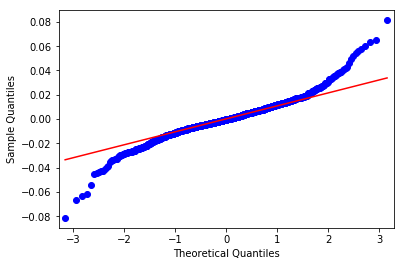

In [33]:
_ = qqplot(arma_fits[0].resid, line='q')

## TO DO...

### 2. State Space Methods? Maybe `tomorrow`, i.e. l don't know when...
$$
y_t= Z_t * alpha_t + d_t + e_t
$$
$$
alpha_t= T_t * alpha_{t−1} + c_t + R_t * eta_t
$$

$$
e_t∼N(0,H_t)
$$
$$
eta_t∼N(0,Q_t)
$$

### 3. Signal Estimation

In [31]:
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

def transform_fft(x):
    featurizer = sklearn.pipeline.FeatureUnion([
        ('rbf1', RBFSampler(gamma=5.0, n_components=50)),
        ('rbf2', RBFSampler(gamma=2.0, n_components=50)),
        ('rbf3', RBFSampler(gamma=1.0, n_components=50)),
        ('rbf4', RBFSampler(gamma=0.5, n_components=50)),
    ])
    return featurizer.fit_transform(x)

In [32]:
from sklearn.model_selection import TimeSeriesSplit